In [1]:
# !pip install git+https://github.com/crispitagorico/sigkernel.git
# !git clone 'https://github.com/ryanmccrickerd/rough_bergomi.git'

In [1]:
import numpy as np
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time

from rbergomi import rBergomi_MC_pricer, rBergomi_sigkernel_pricer
from utils import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# model parameters
T, a, xi, eta, rho = 1., -.4, .055, 1.9, -.9
n_increments       = 20
log_strike         = -5.  
payoff             = lambda x: max(np.exp(x) - np.exp(log_strike), 0.) # call
# payoff             = lambda x: int(np.exp(x) - np.exp(log_strike) > 0) # digital
x_var              = 5.

# evaluation points
n_eval       = 50
t_inds_eval  = np.random.choice(n_increments, n_eval)
xs_eval      = generate_xs(xi, x_var, t_inds_eval)
paths_eval   = generate_theta_paths(t_inds_eval, n_increments, T, a)

# true prices
n_samples_MC_exact = 10000
mc_pricer_exact = rBergomi_MC_pricer(n_increments, n_samples_MC_exact, T, a, xi, eta, rho)
mc_prices_exact = mc_pricer_exact.fit_predict(t_inds_eval, xs_eval, paths_eval, payoff)

# sigkernel parameters
sigma_t, sigma_x, sigma_sig, dyadic_order, max_batch = 0.5, 0.5, 1e5, 1, 50

In [10]:
error_fn, error_name, precisions = l2_error, 'L2_error', [1e-2, 1e-3, 1e-4]
m, n = 300, 100
sig_pricer = rBergomi_sigkernel_pricer(n_increments, x_var, m, n, T, a, xi, eta, rho, 
                                       sigma_t, sigma_x, sigma_sig, dyadic_order, max_batch, device)
sig_pricer.fit(payoff)
sig_prices = sig_pricer.predict(t_inds_eval, xs_eval, paths_eval) 

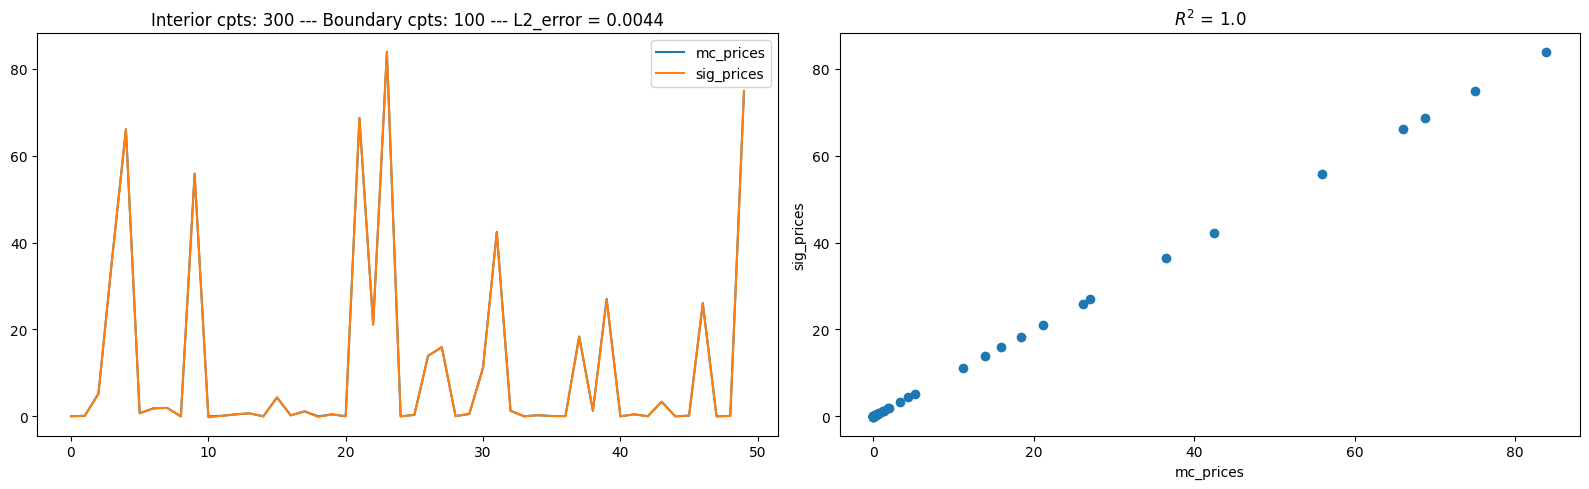

In [11]:
plot_results(mc_prices_exact, sig_prices, m, n, error_fn, error_name)

In [ ]:
# error_fn, error_name, precisions = l2_error, 'L2_error', [1e-2, 1e-3, 1e-4]
error_fn, error_name, precisions = linf_error, 'Linf_error', [1e-1]

n_samples_mc, error_mc = 0, 1e9
m, n, error_sig        = 0, 0, 1e9

for precision in precisions:

    # MC prices
    while error_mc > precision:
        n_samples_mc += 5000
        mc_pricer = rBergomi_MC_pricer(n_increments, n_samples_mc, T, a, xi, eta, rho)
        t0 = time.time()
        mc_prices = mc_pricer.fit_predict(t_inds_eval, xs_eval, paths_eval, payoff)
        t1 = time.time()
        error_mc  = error_fn(mc_prices, mc_prices_exact)

    print('Monte Carlo | %r: %2.5f | sample paths: %r | time: %2.4f sec' % (error_name, precision, n_samples_mc, t1-t0))
    
    # PPDE prices
    while error_sig > precision:
        m += 100
        n += 80
        sig_pricer = rBergomi_sigkernel_pricer(n_increments, x_var, m, n, T, a, xi, eta, rho, sigma_t, sigma_x, sigma_sig, dyadic_order, max_batch, device)
        sig_pricer.fit(payoff)
        t0 = time.time()
        sig_prices = sig_pricer.predict(t_inds_eval, xs_eval, paths_eval) 
        t1 = time.time()
        error_sig = error_fn(sig_prices, mc_prices_exact)
        torch.cuda.empty_cache()

    print('PPDE (sigkernel) | %r: %2.5f | collocation points: (%r,%r) | time: %2.4f sec \n' % (error_name, precision, m, n, (t1-t0)))
